In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq


In [2]:
def d1_d2(S, K, T, r, sigma, q=0.0):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return d1, d2


def bs_price(S, K, T, r, sigma, q=0.0, option="call"):
    d1, d2 = d1_d2(S, K, T, r, sigma, q)
    if option == "call":
        return S * np.exp(-q*T) * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)
    else:
        return K * np.exp(-r*T) * norm.cdf(-d2) - S * np.exp(-q*T) * norm.cdf(-d1)


In [3]:
def bs_greeks(S, K, T, r, sigma, q=0.0):
    d1, d2 = d1_d2(S, K, T, r, sigma, q)
    pdf = norm.pdf(d1)

    delta_call = np.exp(-q*T) * norm.cdf(d1)
    gamma = np.exp(-q*T) * pdf / (S * sigma * np.sqrt(T))
    vega = S * np.exp(-q*T) * pdf * np.sqrt(T)

    theta_call = (
        -S * pdf * sigma * np.exp(-q*T) / (2*np.sqrt(T))
        - r*K*np.exp(-r*T)*norm.cdf(d2)
        + q*S*np.exp(-q*T)*norm.cdf(d1)
    )

    rho_call = K * T * np.exp(-r*T) * norm.cdf(d2)

    return {
        "delta": delta_call,
        "gamma": gamma,
        "vega": vega,
        "theta": theta_call,
        "rho": rho_call
    }


In [4]:
def implied_vol(price, S, K, T, r, q=0.0, option="call"):
    def objective(sigma):
        return bs_price(S, K, T, r, sigma, q, option) - price

    return brentq(objective, 1e-6, 5.0)


In [5]:
def mc_price(S, K, T, r, sigma, q=0.0, option="call", n=200_000):
    Z = np.random.randn(n)
    ST = S * np.exp((r - q - 0.5*sigma**2)*T + sigma*np.sqrt(T)*Z)

    if option == "call":
        payoff = np.maximum(ST - K, 0)
    else:
        payoff = np.maximum(K - ST, 0)

    return np.exp(-r*T) * payoff.mean()


In [6]:
S, K, T, r, q = 100, 100, 1, 0.03, 0.0

vols = np.linspace(0.05, 0.50, 50)
call_prices = [bs_price(S, K, T, r, v, q, "call") for v in vols]

df = pd.DataFrame({
    "Volatility": vols,
    "Call Price": call_prices
})

df.head()


,Volatility,Call Price
0,0.050000,3.786114
1,0.059184,4.096038
2,0.068367,4.418820
3,0.077551,4.750158
4,0.086735,5.087441


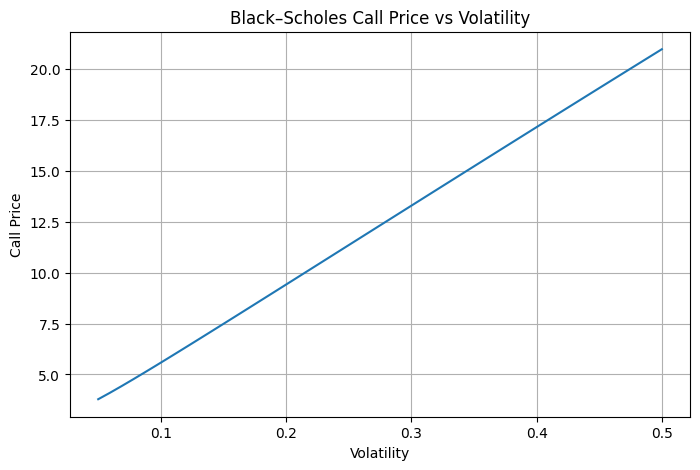

In [7]:
plt.figure(figsize=(8,5))
plt.plot(df["Volatility"], df["Call Price"])
plt.xlabel("Volatility")
plt.ylabel("Call Price")
plt.title("Black–Scholes Call Price vs Volatility")
plt.grid(True)
plt.show()


In [8]:
sigma = 0.20

print("Call price:", bs_price(S, K, T, r, sigma, q))
print("Put price:", bs_price(S, K, T, r, sigma, q, "put"))

print("\nGreeks:")
for k, v in bs_greeks(S, K, T, r, sigma, q).items():
    print(f"{k}: {v}")

market_price = bs_price(S, K, T, r, sigma, q)
print("\nImplied vol from market price:", implied_vol(market_price, S, K, T, r, q))

print("\nMonte Carlo price:", mc_price(S, K, T, r, sigma, q))


Call price: 9.413403383853016
Put price: 6.457956738703835

Greeks:
delta: 0.5987063256829237
gamma: 0.019333405840142464
vega: 38.66681168028493
theta: -5.380398043561674
rho: 50.457229184439356

Implied vol from market price: 0.199999999999998

Monte Carlo price: 9.480189471339157
